# 🖩 OLS na Regressão Linear versus Entropia Cruzada na Logística

Na regressão linear usamos o erro quadrático médio (MSE):

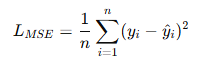

Ou seja, o modelo é penalizado conforme o quadrado da diferença entre o valor previsto e o valor real. Isso faz sentido porque yi é contínuo, como um valor de pressão arterial, glicemia, etc.

Mas na regressão logística nosso 𝑦𝑖 não é contínuo — ele é binário (0 ou 1).
Além disso, o modelo não prevê um valor contínuo, e sim uma probabilidade.

Então, não faz sentido usar o erro quadrático — o que queremos é avaliar o quão bem as probabilidades previstas se alinham com as classes reais.

O que fazemos na logística é calcular quanto o modelo “se surpreende” com o resultado verdadeiro.

* Se o modelo prevê 0.9 e o resultado é 1 → ótimo (baixa surpresa).
* Se o modelo prevê 0.9 e o resultado é 0 → alta surpresa (grande erro).

👉 Essa surpresa é medida por uma função logarítmica — e é por isso que o nome é log loss ou entropia cruzada.

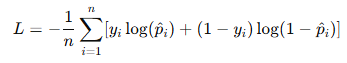

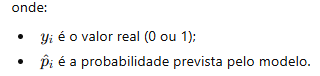

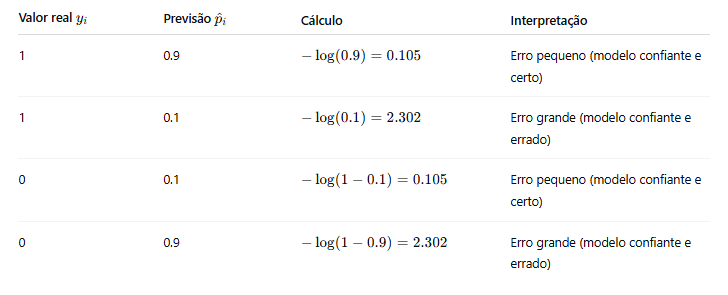

A tabela demonstra que o logarítmico faz o erro crescer muito quando o modelo está confiante e errado. Isso força o modelo a “respeitar” a incerteza e ajustar melhor as probabilidades.

**Por que o nome entropia cruzada?**
“Entropia” vem da ideia de incerteza média de um sistema.
A entropia cruzada mede o quanto uma distribuição prevista (as probabilidades do modelo) se distancia da distribuição real (os rótulos 0 e 1).

* Se as distribuições forem idênticas → perda = 0.
* Quanto mais diferentes → maior a perda.

👉 É uma forma matemática de dizer:
“Quão distante o que o modelo acredita está da verdade?”



> A regressão logística aprende por verossimilhança:
ela busca os parâmetros que tornam os dados observados mais prováveis,
e faz isso minimizando a entropia cruzada, que mede o quanto o modelo “se engana” nas probabilidades previstas.



#✉️ Regressão no Statsmodels

In [17]:
# 1. Importar bibliotecas
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score

# 2. Criar dados simulados de saúde
np.random.seed(42)
n = 100

idade = np.random.randint(25, 70, n)
imc = np.random.normal(27, 4, n)
sexo = np.random.choice(['M', 'F'], size=n)

# Probabilidade de ter diabetes (classe 1)
logit = -6 + 0.06*idade + 0.12*imc - 0.45*(sexo=='F')
p = 1 / (1 + np.exp(-logit))
diabetes = np.random.binomial(1, p)

df = pd.DataFrame({'idade': idade, 'imc': imc, 'sexo': sexo, 'diabetes': diabetes})
df.head()

,idade,imc,sexo,diabetes
0,63,30.722338,M,1
1,53,29.711070,F,1
2,39,29.793761,F,0
3,67,27.694408,F,0
4,32,29.649138,F,0


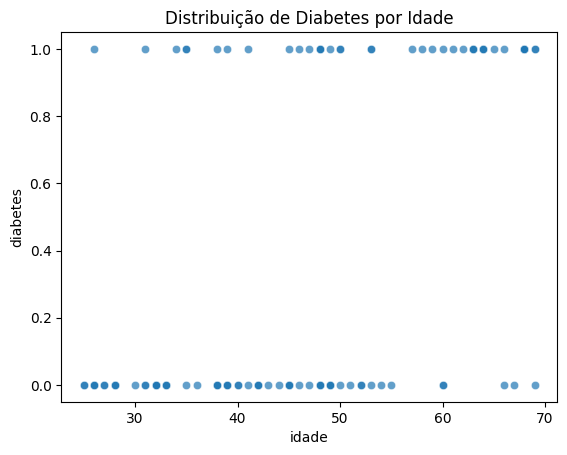

In [18]:
# 3. Exploração inicial
sns.scatterplot(x='idade', y='diabetes', data=df, alpha=0.7)
plt.title('Distribuição de Diabetes por Idade')
plt.show()

In [28]:
# 4. Preparar os dados para regressão logística
df_dummies = pd.get_dummies(df, drop_first=True, dtype=int)

In [29]:
X = df_dummies[['idade', 'imc', 'sexo_M']]

In [30]:
X = sm.add_constant(X)
y = df_dummies['diabetes']

In [31]:
# Verificar se há valores nulos
print(X.dtypes)
print(y.dtypes)
print(X.isna().sum())
print(y.isna().sum())

const     float64
idade       int64
imc       float64
sexo_M      int64
dtype: object
int64
const     0
idade     0
imc       0
sexo_M    0
dtype: int64
0


In [32]:
# 5. Rodar o modelo
modelo = sm.Logit(y, X)
resultado = modelo.fit()

Optimization terminated successfully.
         Current function value: 0.509513
         Iterations 6


In [33]:
print(resultado.summary())

                           Logit Regression Results                           
Dep. Variable:               diabetes   No. Observations:                  100
Model:                          Logit   Df Residuals:                       96
Method:                           MLE   Df Model:                            3
Date:                Tue, 28 Oct 2025   Pseudo R-squ.:                  0.2472
Time:                        16:36:04   Log-Likelihood:                -50.951
converged:                       True   LL-Null:                       -67.686
Covariance Type:            nonrobust   LLR p-value:                 2.564e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.9481      2.505     -3.971      0.000     -14.859      -5.038
idade          0.1021      0.022      4.558      0.000       0.058       0.146
imc            0.1650      0.068      2.421      0.0

**Interpretação do modelo como um todo**


| Indicador                   | Interpretação                                                                                                                                   |
| --------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------- |
| **Dep. Variable**           | A variável resposta (aqui, `diabetes`)                                                                                                          |
| **No. Observations = 100**  | Foram usadas 100 observações                                                                                                                    |
| **Df Model = 3**            | Há 3 variáveis independentes (idade, imc, sexo)                                                                                                 |
| **Method = MLE**            | Método de estimação é *Maximum Likelihood Estimation* (verossimilhança máxima)                                                                  |
| **Pseudo R-squ. = 0.2472**  | O modelo explica cerca de **24,7%** da variabilidade das chances (log-odds) de ter diabetes                                                     |
| **LLR p-value = 2.564e-07** | O modelo como um todo é estatisticamente significativo (p < 0,001) — ou seja, pelo menos uma variável tem relação real com a chance de diabetes |


**Intepretação das variáveis**

| Variável               | Coeficiente | p-valor | Interpretação                                                                                                                                                                        |
| ---------------------- | ----------- | ------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Intercepto (const)** | -9.9481     | 0.000   | Quando idade, IMC e sexo = 0, a log-odds de diabetes é -9.94 → probabilidade muito baixa. É o ponto base.                                                                            |
| **Idade**              | +0.1021     | 0.000   | Altamente significativa. A cada **1 ano a mais de idade**, o *log-odds* de diabetes aumenta em 0.12, mantendo IMC e sexo constantes.                                                 |
| **IMC**                | +0.1650     | 0.015   | Significativo. Cada **1 unidade a mais de IMC** aumenta o *log-odds* de diabetes em 0.165, mantendo os demais fixos.                                                                 |
| **Sexo_M**             | +0.5304     | 0.291   | Não significativo (p > 0.05). Ou seja, **não há evidência** de diferença estatisticamente relevante entre homens e mulheres quanto à chance de diabetes, após controlar idade e IMC. |


**Convertendo os Coeficientes para Odds Ratio**

A interpretação mais intuitiva em saúde é pelo odds ratio (OR), onde:

image.png

In [36]:
  # 6. Interpretar coeficientes
odds_ratios = np.exp(resultado.params)
print("\nODDS RATIOS:")
print(odds_ratios)


ODDS RATIOS:
const     0.000048
idade     1.107516
imc       1.179411
sexo_M    1.699619
dtype: float64


| Variável   | Coeficiente (β) | OR = e^β | Interpretação                                                                        |
| ---------- | --------------- | -------- | ------------------------------------------------------------------------------------ |
| **Idade**  | 0.1021          | 1.10     | Cada ano a mais aumenta as chances de diabetes em **10%**, mantendo IMC e sexo fixos |
| **IMC**    | 0.1650          | 1.18     | Cada ponto a mais no IMC aumenta as chances em **18%**                               |
| **Sexo_M** | 0.5304          | 1.70     | Homens têm **1,7x mais chance**, mas o efeito **não é significativo** (p=0.29)       |


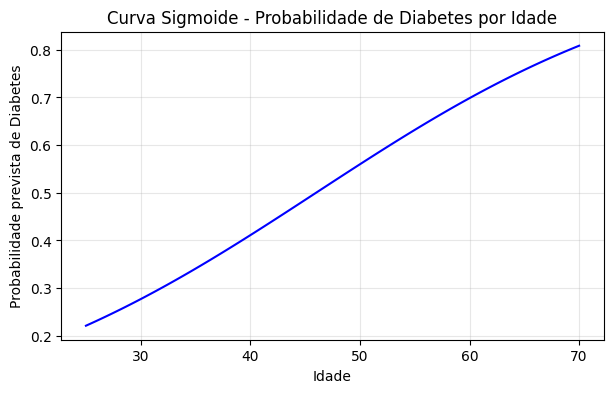

In [37]:
# Visualizar curva sigmoide (probabilidade vs idade)
idades_grid = np.linspace(25, 70, 100)
logit_grid = -6 + 0.06*idades_grid + 0.12*27
prob_grid = 1 / (1 + np.exp(-logit_grid))

plt.figure(figsize=(7,4))
plt.plot(idades_grid, prob_grid, color='blue')
plt.xlabel("Idade")
plt.ylabel("Probabilidade prevista de Diabetes")
plt.title("Curva Sigmoide - Probabilidade de Diabetes por Idade")
plt.grid(alpha=0.3)
plt.show()